In [1]:
!pip install datasets transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.4 MB/s eta 0:00:00


### Data Loading and Visualization

#### Load Emotions Dataset

In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")
emotions

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

##### HuggingFace Datasets is based on Apache Arrow, which defines a typed columnar format that is more memory efficient than native Python.

In [3]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

##### We can access one row or several rows with a slice

In [4]:
train_ds[16]

{'text': 'i didnt really feel that embarrassed', 'label': 0}

In [5]:
print(train_ds[:3])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong'], 'label': [0, 0, 3]}


In [6]:
print(train_ds["text"][:3])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong']


##### The data type of the text column is string, while the label column is a special ClassLabel object that contains information about the class names and their mapping to integers

In [7]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


##### Loading data into dataframes without changing underlying data format

In [8]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
# The labels are represented as integers, so let’s use the int2str()
# method of the label feature to create a new column in our
# DataFrame with the corresponding label names

def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


##### Visualizing class distribution

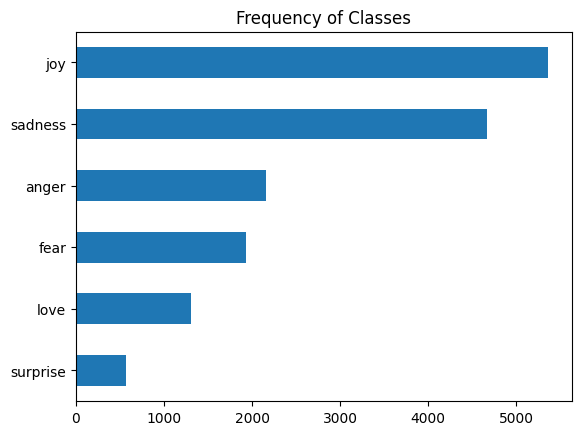

In [10]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

##### Transformer models have a maximum input sequence length that is referred to as the maximum context size.
##### For applications using DistilBERT, the maximum context size is 512 tokens.

##### Finding Document Lengths

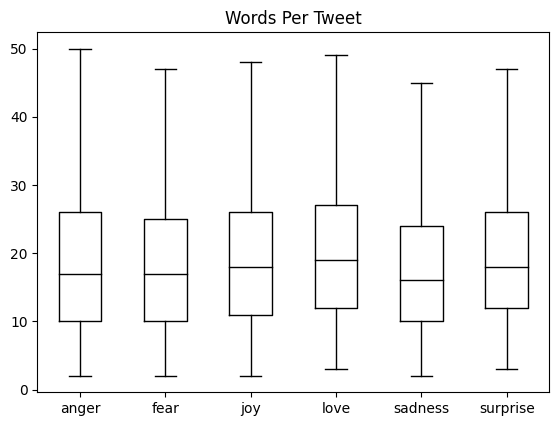

In [11]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

##### For each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size of 512

##### Reset the output format of our dataset since we don't need the DataFrame format anymore

In [12]:
emotions.reset_format()

### Tokenization

##### Character Tokenization - Feed each character individually to the model
##### This ignores any structure in the text and treats the whole string as a stream of characters. Although this helps deal with misspellings and rare words, the main drawback is that linguistic structures such as words need to be learned from the data. This requires significant compute, memory, and data.

##### Word Tokenization - Split text into words and map each word to an integer. Using words from the outset enables the model to skip the step of learning words from characters, and thereby reduces the complexity of the training process.
##### One potential problem with this tokenization scheme: punctuation is not accounted for, so NLP. is treated as a single token.
##### Also to lower the parameters we limit the vocabulary and discard rare words by considering, say, the 100,000 most common words or we map them as“unknown” in the corpus hence we lose some potentially important information in the process

##### Subword Tokenization

##### The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. Main feature is it is learned from the pretraining corpus.
##### What we do is that :-
##### 1. Split rare words into smaller units to allow the model to deal with complex words and misspellings.
##### 2. Keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size.


In [35]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Set batch_size=None, our tokenize() function will be applied on the full dataset as a single batch
#This ensures that the input tensors and attention masks have the same shape globally
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [15]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
# The first element of input_ids is shorter than the second, so zeros have been added to that element to make them the same length.
# These zeros have a corresponding [PAD] token in the vocabulary, and the set of special tokens also includes the [CLS] and [SEP] tokens
# Special [CLS] and [SEP] tokens have been added to the start and end of the sequence.
# These tokens differ from model to model, but their main role is to indicate the start and end of a sequence.
# The tokens have each been lowercased, which is a feature of this particular checkpoint.
# The ## prefix in ##izing and ##p means that the preceding string is not whitespace;
# any token with this prefix should be merged with the previous token when you convert the tokens back to a string

# The AutoTokenizer class also has several attributes that provide information about the tokenizer like
# tokenizer.vocab_size , tokenizer.model_max_length, tokenizer.model_input_names

# When using pretrained models, it is really important to make sure that you use the same tokenizer that the model was trained with

In [16]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


### Training a Text Classifier

#### Option 1 : Using pretrained models

In [ ]:
# Main Idea is use to use the hidden states as fixed features
# Transformers have a class called AutoModel that has a from_pretrained() method to load the weights of a pretrained model
# The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states

In [17]:
import torch
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Depending on the model configuration, the output can contain several objects, such as the hidden states, losses, or attentions,
# arranged in a class similar to a namedtuple in Python.
# In our example, the model output is an instance of BaseModelOutput, and we can simply access its attributes by name.
# The current model "distilbert-base-uncased" returns only one attribute, which is the last hidden state

# For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature.
# Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state
# We do this to the whole dataset by creating a new hidden_state column that stores all these vectors

##### Extracting the last hidden states

In [18]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names} # Extract last hidden states

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state # Return vector for [CLS] token

    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [19]:
# Our model expects tensors as inputs, the next thing to do is convert the input_ids and attention_mask columns to the "torch" format
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Extract the hidden states across all splits in one go
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

# Applying the extract_ hidden_ states() function has added a new hidden_state column to our dataset
emotions_hidden["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [ ]:
# Now that we have the hidden states associated with each tweet, the next step is to train a classifier on them.
# To do that, we’ll need a feature matrix of the hidden states as input features and the labels as targets

##### Creating a feature matrix

In [20]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

##### Training a simple classifier

In [21]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

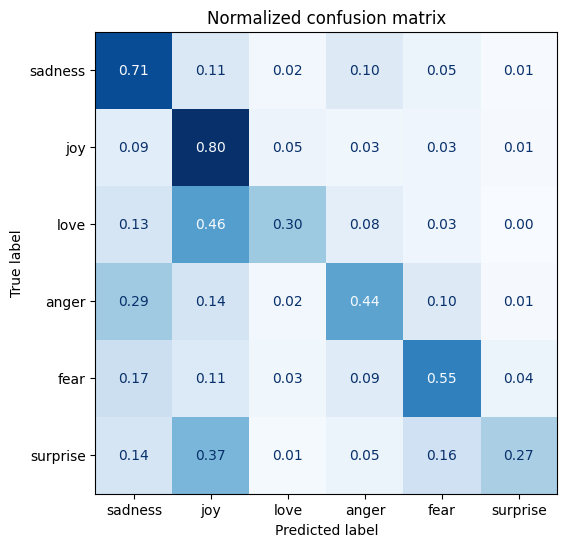

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

labels = emotions["train"].features["label"].names
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

#### Option 2 : Fine-Tuning Transformers

In [ ]:
# When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head

##### Loading a pretrained model

In [ ]:
# AutoModelForSequenceClassification model has a classification head on top of the pretrained model outputs,
# which can be easily trained with the base model by specifying how many labels the model has to predict

In [23]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

##### Defining the performance metrics

In [24]:
!pip install transformers[torch]

In [ ]:
#!pip install accelerate==0.20.1

In [25]:
# This function receives an EvalPrediction object (which is a named tuple with predictions and label_ids attributes)
# and needs to return a dictionary that maps each metric’s name to its value

from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [26]:
# To define the training parameters, we use the TrainingArguments class.
# This class stores a lot of information and gives you fine-grained control
# over the training and evaluation. The most important argument to specify
# is output_dir, which is where all the artifacts from training are stored

from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [27]:
# Instantiate and fine-tune our model with the Trainer

from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

In [28]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.851600,0.333265,0.896500,0.891163
2,0.252000,0.216128,0.929000,0.928902


TrainOutput(global_step=500, training_loss=0.5517961349487305, metrics={'train_runtime': 233.06, 'train_samples_per_second': 137.304, 'train_steps_per_second': 2.145, 'total_flos': 720342861696000.0, 'train_loss': 0.5517961349487305, 'epoch': 2.0})

In [ ]:
# We can take a more detailed look at the training metrics by calculating the confusion matrix.
# To visualize the confusion matrix, we first need to get the predictions on the validation set.
# The predict() method of the Trainer class returns several useful objects we can use for evaluation

In [29]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [30]:
preds_output.metrics

{'test_loss': 0.21612820029258728,
 'test_accuracy': 0.929,
 'test_f1': 0.9289021073679498,
 'test_runtime': 3.9008,
 'test_samples_per_second': 512.71,
 'test_steps_per_second': 8.203}

In [31]:
y_preds = np.argmax(preds_output.predictions, axis=1)

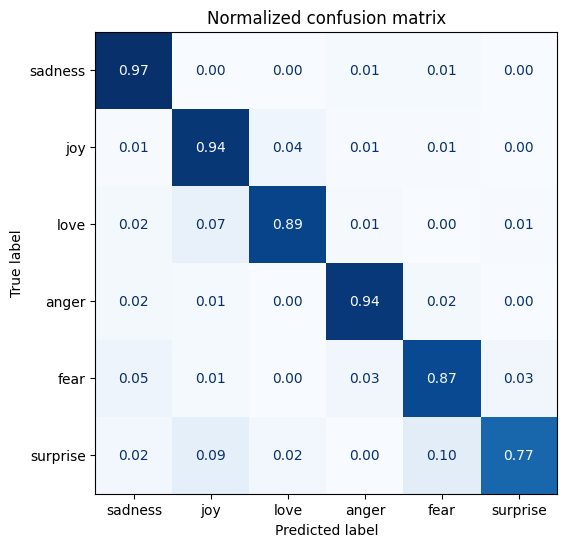

In [32]:
plot_confusion_matrix(y_preds, y_valid, labels)

##### Model Save, Load and Inference

In [33]:
# Save the model
saved_path = "saved_model/fine_tuned_model"
trainer.save_model(saved_path)

In [34]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(saved_path)

In [38]:
#CReating a pipeline using the tokenizer + pretrained fine tuned model
from transformers import pipeline
tokenizer = tokenizer
emotions_classifier_fine_tuned = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [46]:
custom_tweet = "I saw a movie today and it was really good."
preds = emotions_classifier_fine_tuned(custom_tweet, top_k=None)

In [47]:
preds

[{'label': 'LABEL_1', 'score': 0.9663867354393005},
 {'label': 'LABEL_2', 'score': 0.011432147584855556},
 {'label': 'LABEL_0', 'score': 0.010192321613430977},
 {'label': 'LABEL_5', 'score': 0.0046951500698924065},
 {'label': 'LABEL_3', 'score': 0.003988520707935095},
 {'label': 'LABEL_4', 'score': 0.003305168356746435}]

In [50]:
# We need to sort the labels in order to get the correct format for displaying
preds_df = pd.DataFrame(preds).sort_values(by=['label'])

In [51]:
preds_df

,label,score
2,LABEL_0,0.010192
0,LABEL_1,0.966387
1,LABEL_2,0.011432
4,LABEL_3,0.003989
5,LABEL_4,0.003305
3,LABEL_5,0.004695


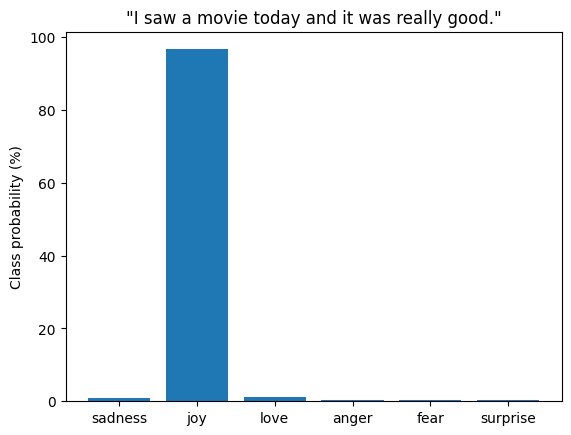

In [52]:
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()